In [1]:
!pip install matplotlib numpy Pillow tqdm opencv-python torch torchvision albumentations

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# Set device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [3]:
## Data Loading and Augmentation

In [4]:
class BarnacleDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.img_files = sorted(glob(os.path.join(data_dir, 'imgs', '*.png')))
    def __len__(self):
        return len(self.img_files)
    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = img_path.replace('imgs', 'masks')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = mask / 255.0
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

In [5]:
## U-Net Model Definition

In [6]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [7]:
## U-Net Model Definition

In [8]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
## Data Preparation and Visualization

In [10]:
# Data augmentation

# Create datasets and dataloaders
train_dataset = BarnacleDataset('../data/tiles/train', transform=False)
val_dataset = BarnacleDataset('../data/tiles/val')
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

print(f'Training samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')

Training samples: 196
Validation samples: 252


In [11]:
## Debugging through visualization and analysis of the empty masks

Mask unique values: [0. 1.], sum: 1561.0
Image min: 0.0 max: 0.88235295 mean: 0.3217271


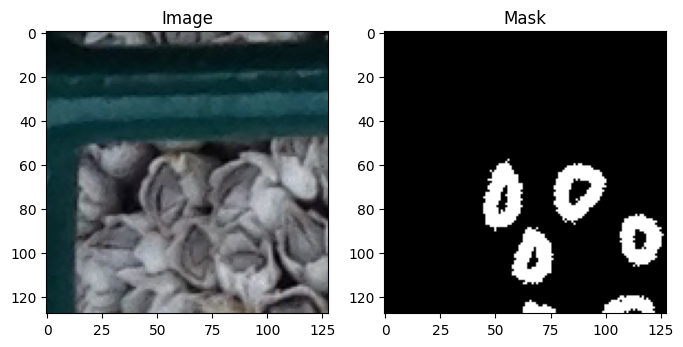

Mask unique values: [0. 1.], sum: 2779.0
Image min: 0.0 max: 0.90588236 mean: 0.33444485


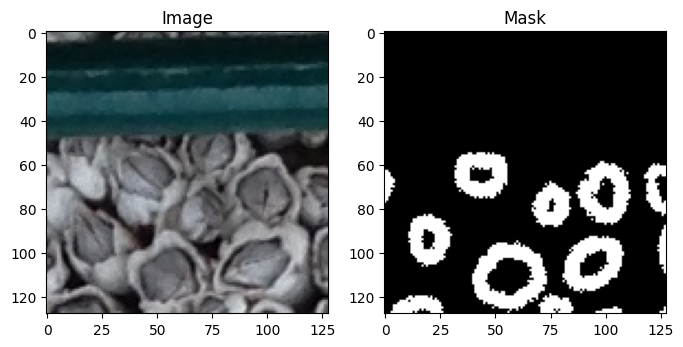

Mask unique values: [0. 1.], sum: 3321.0
Image min: 0.0 max: 0.8745098 mean: 0.33661366


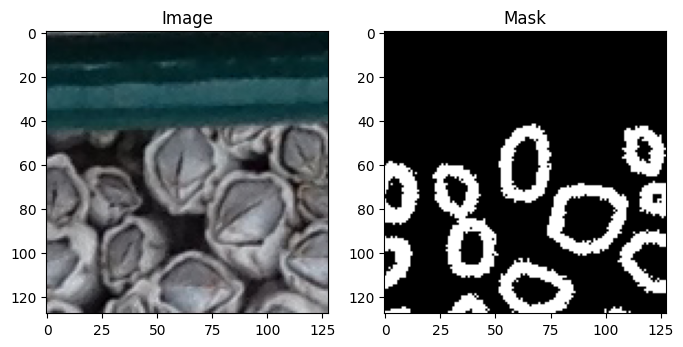

Mask unique values: [0. 1.], sum: 3587.0
Image min: 0.0 max: 0.8784314 mean: 0.36143616


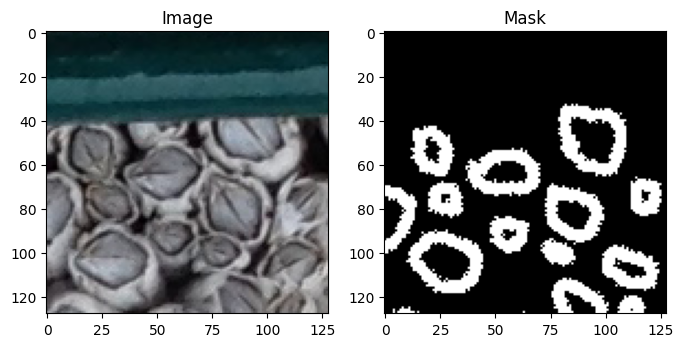

Mask unique values: [0. 1.], sum: 3044.0
Image min: 0.0 max: 0.8784314 mean: 0.35875142


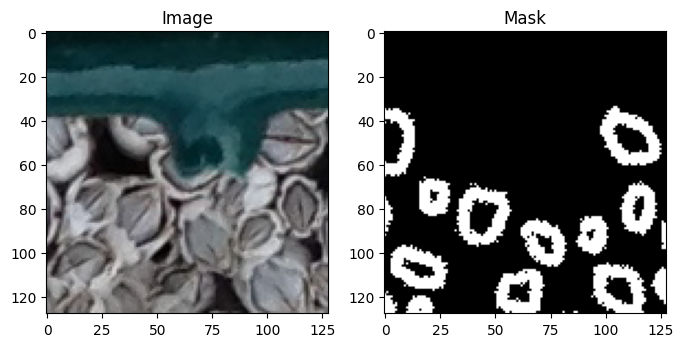

In [12]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(5):
    img, mask = train_dataset[i]
    img_np = img.permute(1,2,0).numpy() if hasattr(img, 'permute') else np.array(img)
    mask_np = mask.squeeze().numpy() if hasattr(mask, 'numpy') else np.array(mask)
    print(f"Mask unique values: {np.unique(mask_np)}, sum: {mask_np.sum()}")
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow((img_np * 255).astype(np.uint8))
    plt.title("Image")
    plt.subplot(1,2,2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Mask")
    print("Image min:", img_np.min(), "max:", img_np.max(), "mean:", img_np.mean())
    plt.show()

In [13]:
   empty = 0
   for i in range(len(train_dataset)):
       _, mask = train_dataset[i]
       mask_np = mask.squeeze().numpy() if hasattr(mask, 'numpy') else np.array(mask)
       if np.sum(mask_np) == 0:
           empty += 1
   print(f"Empty masks: {empty} / {len(train_dataset)}")

Empty masks: 0 / 196


In [14]:
## Training and Validation Functions

In [15]:
def dice_score(pred, target):
    pred = torch.sigmoid(pred) > 0.5
    target = target > 0.5
    intersection = (pred & target).sum()
    union = pred.sum() + target.sum()
    return (2 * intersection) / (union + 1e-6)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_dice = 0
    for imgs, masks in tqdm(loader, desc='Training'):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_dice += dice_score(outputs, masks).item()
    return total_loss / len(loader), total_dice / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc='Validation'):
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_dice += dice_score(outputs, masks).item()
    return total_loss / len(loader), total_dice / len(loader)

In [16]:
## Model Training

In [17]:
import os
os.makedirs('../models', exist_ok=True)
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20
train_losses, val_losses, train_dices, val_dices = [], [], [], []
best_val_dice = 0
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_dice = validate_epoch(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), '../models/best_barnacle_unet.pth')
        print(f'New best model saved! Dice: {val_dice:.4f}')
    if epoch > 5 and val_dice < 0.1:
        print('Early stopping due to poor performance')
        break


Epoch 1/20


Validation: 100%|█████████████████████| 32/32 [00:03<00:00, 10.33it/s]


Train Loss: 0.6328, Train Dice: 0.4055
Val Loss: 0.6005, Val Dice: 0.0110
New best model saved! Dice: 0.0110

Epoch 2/20


Validation: 100%|█████████████████████| 32/32 [00:03<00:00, 10.17it/s]


Train Loss: 0.5251, Train Dice: 0.5219
Val Loss: 0.4186, Val Dice: 0.0049

Epoch 3/20


Validation: 100%|█████████████████████| 32/32 [00:03<00:00,  8.92it/s]


Train Loss: 0.4413, Train Dice: 0.5924
Val Loss: 0.4228, Val Dice: 0.0279
New best model saved! Dice: 0.0279

Epoch 4/20


Validation: 100%|█████████████████████| 32/32 [00:03<00:00,  9.22it/s]


Train Loss: 0.3863, Train Dice: 0.6379
Val Loss: 0.4017, Val Dice: 0.0536
New best model saved! Dice: 0.0536

Epoch 5/20


Validation: 100%|█████████████████████| 32/32 [00:03<00:00,  9.23it/s]


Train Loss: 0.3490, Train Dice: 0.6920
Val Loss: 0.3985, Val Dice: 0.0494

Epoch 6/20


Validation: 100%|█████████████████████| 32/32 [00:03<00:00,  9.29it/s]


Train Loss: 0.3204, Train Dice: 0.7388
Val Loss: 0.4054, Val Dice: 0.1204
New best model saved! Dice: 0.1204

Epoch 7/20


Validation: 100%|█████████████████████| 32/32 [00:03<00:00,  9.20it/s]

Train Loss: 0.2914, Train Dice: 0.7876
Val Loss: 0.3780, Val Dice: 0.0459
Early stopping due to poor performance


In [18]:
## Training Curves

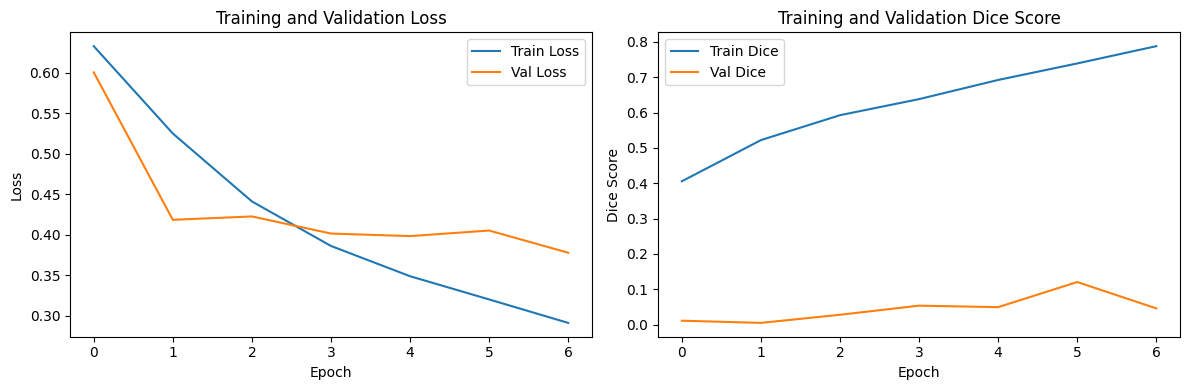

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Training and Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
## Sample Predictions on Validation Data

/var/folders/p2/cdj69_b90yd1md9r563bvt8w0000gn/T/ipykernel_38097/3639788854.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/b

Final Dice Score: 0.2630


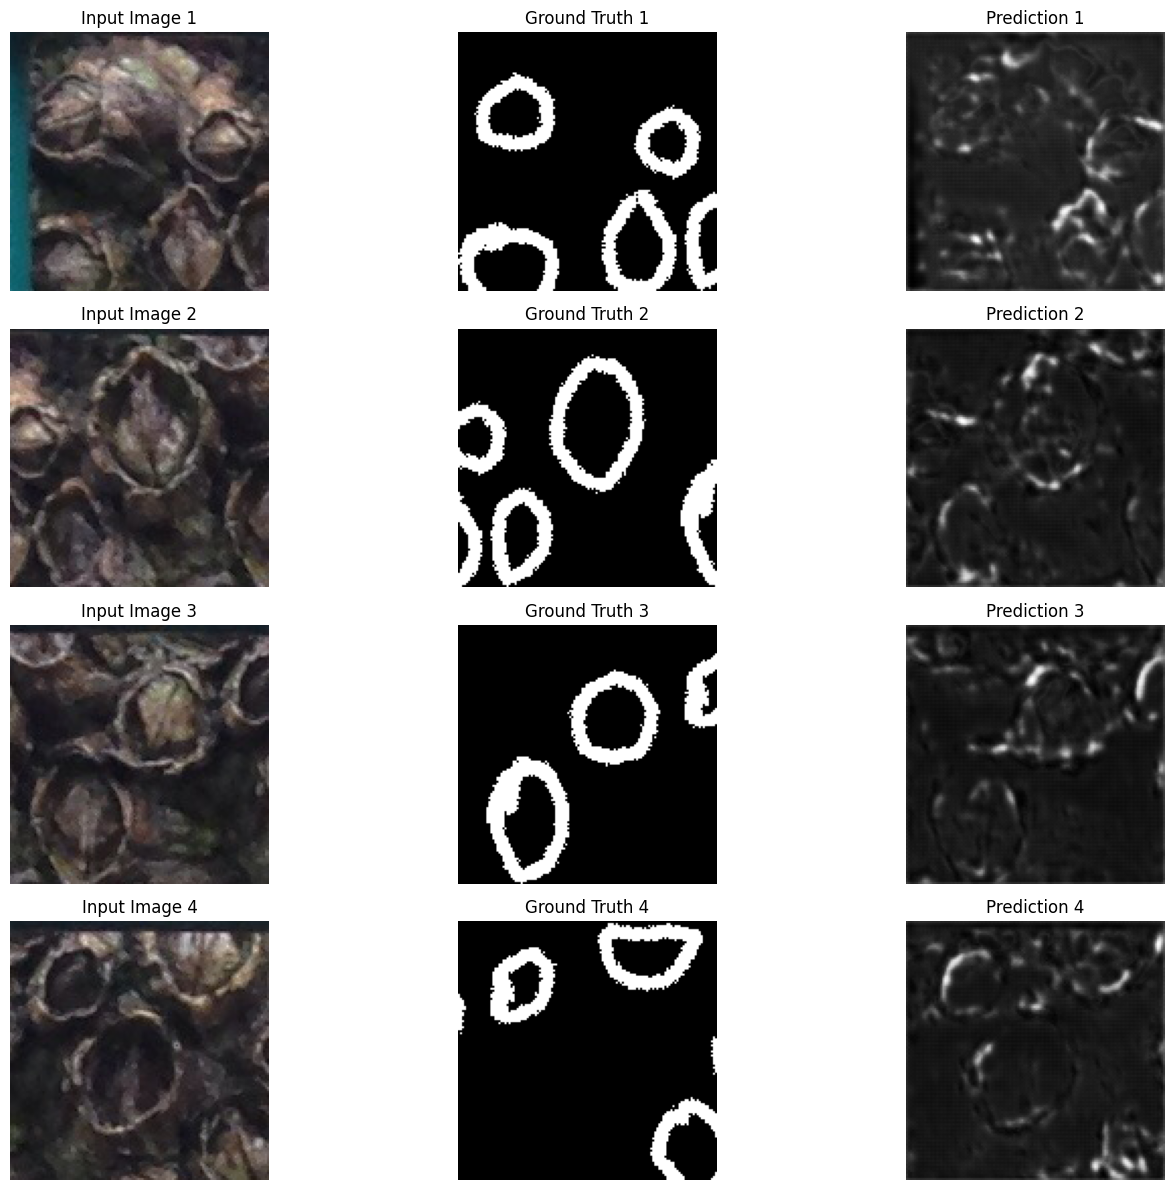

In [21]:
model.load_state_dict(torch.load('../models/best_barnacle_unet.pth'))
model.eval()
test_batch = next(iter(val_loader))
test_imgs, test_masks = test_batch
with torch.no_grad():
    test_imgs = test_imgs.to(device)
    predictions = model(test_imgs)
    predictions = torch.sigmoid(predictions)
final_dice = dice_score(predictions, test_masks.to(device)).item()
print(f'Final Dice Score: {final_dice:.4f}')
plt.figure(figsize=(15, 12))
for i in range(4):
    plt.subplot(4, 3, i*3+1)
    plt.imshow(test_imgs[i].cpu().permute(1, 2, 0))
    plt.title(f'Input Image {i+1}')
    plt.axis('off')
    plt.subplot(4, 3, i*3+2)
    plt.imshow(test_masks[i].squeeze().cpu(), cmap='gray')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')
    plt.subplot(4, 3, i*3+3)
    plt.imshow(predictions[i].squeeze().cpu(), cmap='gray')
    plt.title(f'Prediction {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
## Inference on New Images

In [23]:
def predict_full_image(model, img_path, device, out_threshold=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.sigmoid(output)
        mask = (output > out_threshold).float()
    return mask.squeeze().cpu().numpy()
# Example usage:
# pred_mask = predict_full_image(model, 'path/to/new_image.png', device)
# plt.imshow(pred_mask, cmap='gray')
# plt.show()